# Fine-tuning facebook/wav2vec2-large-960h on Common Voice dataset.

This notebook demonstrates dataset preprocessing, tokenizer and feature extraction,
fine-tuning pipeline setup, and visualizes training metrics.

### **Training Pipeline**

**Datasets:**
- **Training and Validation Splits:**
  - Dataset is split into 70% training and 30% validation.
  - Processed into a Hugging Face `Dataset` format for seamless integration with the `Trainer` API.

- **Sanitization:**
  - Ensures that no empty labels exist in the dataset.

**Model:**
- **Pretrained Model:** `facebook/wav2vec2-large-960h`.

**Evaluation Metric:**
- **WER (Word Error Rate):**
  - Measures how well the model transcribes audio compared to the ground truth.


In [1]:
!pip install transformers datasets librosa torchaudio matplotlib IPython


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import torchaudio
from datasets import Dataset
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    Trainer,
    TrainingArguments
)
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch


from torchaudio.transforms import Resample
from tqdm import tqdm
import re
import IPython.display as ipd

/home/coe8/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Training Data Preprocess & Clean-up

- To standardized audio sampling rate ensures compatibility with the pretrained Wav2Vec2 model, which is trained on 16kHz audio.
- And Text normalization improves alignment with the tokenizer and ensures uniformity in text processing.

**Steps:**
- **Dataset Loading and Normalization:** 
  - The CSV file containing audio file paths and corresponding text labels (`cv-valid-train.csv`) is loaded into a DataFrame.
  - Text labels are normalized using `normalize_text`:
    - Removes special characters using a regex (`chars_to_ignore_regex`).
    - Converts text to lowercase.
  
- **Audio Preprocessing:**
  - Audio files are loaded using `torchaudio.load()`, which reads waveform data and sampling rate.
  - Resampled to 16kHz using `torchaudio.transforms.Resample` to match the Wav2Vec2 model requirements.

- **Sanitize datasets**
  - Filter out empty labels
  - Filter out the audio duration out of range which is less than 1sec or greater 15se

- **Traning PC resource limitation handling**
  -  During the data processing , I encountered the excessive memory usage when processing the full cv-valid-train datasets. 
  - Temporaray fix:  Truncate DataFrame with 1000 sample as following code `df = df.head(1000)` for debugging and demo purposes, remove this for full training
  - Resolution: updated implementation to chunk both the train_dataset and val_dataset into smaller parts, process each part separately, merge them into one dataset each (training and validation), sanitize the datasets, and save them as single directories. please refer to **cache_dataset** in **tran-cv.py** 

In [3]:
# Characters to ignore in text normalization
chars_to_ignore_regex = r'[\,\?\.\!\-\;\:\"]'

# Text normalization function
def normalize_text(batch):
    """Normalize text by removing special characters, converting to lowercase, and appending a space."""
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch

# Load the dataset
df = pd.read_csv("cv-valid-train.csv")

# Truncate DataFrame for debugging purposes (remove this for full training)
df = df.head(1000)

# Add complete path to the filename column
df['path'] = df['filename'].apply(lambda x: f"cv-valid-train/{x}")

# Filter out rows with empty or NaN text
df = df[df['text'].notna() & (df['text'].str.strip() != "")]

# Normalize text
df = df.apply(normalize_text, axis=1)

# Split into train (70%) and validation (30%)
train_df = df.sample(frac=0.7, random_state=42)
val_df = df.drop(train_df.index)

# Preprocess function
def preprocess_data(row):
    """Preprocess audio and text data for training."""
    try:
        # Load audio file
        waveform, sr = torchaudio.load(row["path"])
        
        # Resample to 16kHz
        resampler = Resample(orig_freq=sr, new_freq=16000)
        speech = resampler(waveform).squeeze(0).numpy()
        
        # Return processed data
        return {"speech": speech, "text": row["text"]}
    except Exception as e:
        # Log and skip problematic files
        print(f"Error processing file {row['path']}: {e}")
        return None

# Apply preprocessing with progress tracking
print("Processing training data...")
train_data = [
    result for result in tqdm(train_df.apply(preprocess_data, axis=1).to_list()) if result is not None
]

print("Processing validation data...")
val_data = [
    result for result in tqdm(val_df.apply(preprocess_data, axis=1).to_list()) if result is not None
]

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))

print("Dataset processing completed.")

Processing training data...


100%|████████████████████████████████████| 700/700 [00:00<00:00, 5106109.22it/s]


Processing validation data...


100%|████████████████████████████████████| 300/300 [00:00<00:00, 3690003.52it/s]


Dataset processing completed.


### Inspect some random samples of the dataset 

In [4]:
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(train_dataset.remove_columns(["speech"]), num_examples=4)

,text
0,A THIN CIRCLE OF BRIGHT METAL SHOWED BETWEEN THE TOP AND THE BODY OF THE CYLINDER
1,THE CARAVANS HAD BEEN STOPPED AT GIZA FOR SOME TIME WAITING FOR THE WARS TO END
2,MAYBE SHE DIDN'T EVEN REMEMBER HIM
3,ALL I SAW WAS AN ARMY SAID THE BOY


### Examine a random sample audio

In [5]:
# Examine a random sample
rand_idx = random.randint(0, len(train_dataset) - 1)
sample = train_dataset[rand_idx]

print("Sample text:", sample["text"])
print("Playing sample audio...")
ipd.display(ipd.Audio(data=np.asarray(sample["speech"]), autoplay=True, rate=16000))
print("Input array shape:", np.asarray(sample["speech"]).shape)

Sample text: YOU MEAN HERE IN THE CITY
Playing sample audio...


Input array shape: (38784,)


# Pre-training setup

### **1. Tokenizer**

User pretrained tokenizer aligns with the model's vocabulary and ensures consistency in label processing.

**Processor:**
- **`Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")`:**
  - Combines a feature extractor for audio and a tokenizer for text.
  - Tokenizes text into `input_ids` and maps them to the model's vocabulary.

**Text Tokenization:**
- Labels are tokenized with padding and truncation enabled. The `padding_value` for labels is set to `-100` to ignore padded tokens during loss calculation.

### **2. Feature Extraction**

**Audio Feature Extraction:**
- Audio waveforms are directly passed to the `processor` during batch preparation:
  - Converts raw waveforms to log-Mel spectrogram features compatible with Wav2Vec2.

**Padding Strategy:**
- `DataCollatorCTCWithPadding`:
  - Dynamically pads input waveforms to the longest sequence in the batch.
  - Labels are padded to the same length and converted to PyTorch tensors with padding tokens replaced by `-100`.

In [6]:
# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Prepare batch function
def prepare_batch(batch):
    inputs = processor(
        batch["speech"], 
        sampling_rate=16000, 
        return_tensors="pt", 
        padding=True
    )
    labels = processor(
        text=batch["text"], 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    ).input_ids
    inputs["labels"] = labels
    return inputs


# Map the function to datasets
print("Mapping prepare_batch to datasets...")
train_dataset = train_dataset.map(prepare_batch, batched=True)
val_dataset = val_dataset.map(prepare_batch, batched=True)

# Set dataset format for PyTorch
train_dataset.set_format(type="torch", columns=["input_values", "labels"])
val_dataset.set_format(type="torch", columns=["input_values", "labels"])


# Initialize model
print("Initializing model...")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")



Mapping prepare_batch to datasets...


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Initializing model...


Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

### setup data collator for trainer

In [7]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Separate input values and labels
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad input values
        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # Convert label_features into a tensor
        labels = [label["input_ids"] for label in label_features]
        labels_batch = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(label, dtype=torch.long) for label in labels],
            batch_first=True,
            padding_value=self.processor.tokenizer.pad_token_id,
        )

        # Replace padding with -100 to ignore in loss calculation
        labels_batch[labels_batch == self.processor.tokenizer.pad_token_id] = -100
        batch["labels"] = labels_batch

        return batch


In [8]:
# Load evaluation metric
metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Replace padding token IDs with -100
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(pred.label_ids, skip_special_tokens=True)

    # Filter out empty references dynamically
    valid_indices = [i for i, ref in enumerate(label_str) if ref.strip()]
    pred_str = [pred_str[i] for i in valid_indices]
    label_str = [label_str[i] for i in valid_indices]

    # Log random predictions for debugging
    if pred_str and label_str:
        random_index = random.randrange(len(pred_str))
        print(f"Sample Prediction[{random_index}]: {pred_str[random_index]}")
        print(f"Sample Reference[{random_index}]: {label_str[random_index]}")
    else:
        raise ValueError("No valid labels to evaluate.")

    # Compute WER
    wer = metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# setup trainer and run training 

**Hyperparameters (TrainingArguments):**
- `output_dir`: Directory to save checkpoints and logs.
- `evaluation_strategy`: Evaluation every 100 steps.
- `learning_rate`: `2e-5`, suitable for fine-tuning large models.
- `num_train_epochs`: `3`, balanced to avoid overfitting on the limited data subset.
- `per_device_train_batch_size`: `4`, manageable for typical GPU memory.
- `fp16`: Mixed precision for faster training and reduced memory usage.

**Trainer:**
- Combines the model, datasets, data collator, and training arguments for streamlined training.

**Metrics Logging:**
- Logs training and evaluation losses, saving results for later analysis.

**Save the fine-tuned model**
- Save the fine-tuned model in `wav2vec2-large-960h-cv-1000samples` folder  


In [9]:
# Initialize data collator
data_collator = DataCollatorCTCWithPadding(processor=processor)

# Setup training arguments
print("Setting up training arguments...")
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Directory to save results
    evaluation_strategy="steps",     # Evaluate at regular intervals
    eval_steps=100,                  # Evaluate every 100 training steps
    per_device_train_batch_size=4,   # Adjust as per available GPU memory
    per_device_eval_batch_size=4,    # Adjust as per available GPU memory
    learning_rate=2e-5,              # Learning rate
    num_train_epochs=3,              # Total number of epochs
    weight_decay=0.01,               # Weight decay for regularization
    fp16=True,                       # Mixed precision training
    logging_dir="./logs",            # Logging directory
    save_total_limit=2,              # Limit saved checkpoints
    save_steps=500,                  # Save checkpoint every 500 steps
    logging_steps=50,                # Log training metrics every 50 steps
    push_to_hub=False
)

# Setup trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# Run training
print("Starting training...")
train_result = trainer.train()
trainer.save_model("wav2vec2-large-960h-cv-1000samples")

metrics = train_result.metrics
metrics["train_samples"] = len(train_dataset)

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

Setting up training arguments...
Initializing Trainer...
Starting training...


/tmp/ipykernel_24665/2011614904.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label, dtype=torch.long) for label in labels],


Step,Training Loss,Validation Loss,Wer
100,95.055900,50.437141,0.131089
200,88.829600,49.595165,0.114255
300,70.612200,43.654720,0.114255
400,67.944300,40.299397,0.103868
500,60.040600,39.420521,0.097063


Sample Prediction[57]: THEY WERE GIVEN TO ME AS A PRESENT BY A KINGTHE BOY SAID
Sample Reference[57]: THEY WERE GIVEN TO ME AS A PRESENT BY A KING THE BOY SAID
Sample Prediction[12]: HOW DO YOU MEAN
Sample Reference[12]: HOW DO YOU MEAN
Sample Prediction[140]: AT FIRST GLANCEIT WAS REALY NOT VERY EXCITING
Sample Reference[140]: AT THE FIRST GLANCE IT WAS REALY NOT VERY EXCITING
Sample Prediction[125]: THE RESTAURANT WAS QUITE EXPENSIVE
Sample Reference[125]: THE RESTAURANT WAS QUITE EXPENSIVE
Sample Prediction[114]: SHE JOINED UP TO
Sample Reference[114]: SHE JOINED UP TO


/tmp/ipykernel_24665/2011614904.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(label, dtype=torch.long) for label in labels],


***** train metrics *****
  epoch                    =         3.0
  total_flos               = 700802407GF
  train_loss               =     89.0584
  train_runtime            =  0:02:59.68
  train_samples            =         700
  train_samples_per_second =      11.687
  train_steps_per_second   =       2.922


# plot the training result

**Visualization:**
- Plots training and validation losses over steps to monitor convergence.

The plot visualization generated by this code snippet represents the training and validation loss during the training process. Here's a breakdown of its interpretation:

---

### **Key Components of the Plot**
1. **X-Axis (Steps):**
   - Represents the progress of training in terms of steps.
   - For **training loss**, the steps are generated from the number of logged training steps.
   - For **validation loss**, the steps correspond to evaluation intervals (e.g., every `eval_steps`).

2. **Y-Axis (Loss):**
   - Represents the magnitude of the loss values.
   - Lower values indicate better performance, as the model is minimizing the loss during training.

3. **Training Loss Curve:**
   - The line labeled as "Training Loss" depicts the loss computed during training at each logged step.
   - A steady decline in this curve indicates that the model is learning from the training data.

4. **Validation Loss Curve:**
   - The line labeled as "Validation Loss" represents the loss on the validation dataset at specified evaluation intervals.
   - It is used to monitor the model's performance on unseen data.

---

### **How to Interpret the Plot**

1. **Smooth Decline in Training Loss:**
   - Indicates that the model is successfully learning and minimizing the training error.
   - If the training loss plateaus or increases, it may suggest issues such as the learning rate being too low or high, or the model overfitting.

2. **Validation Loss Behavior:**
   - If validation loss decreases alongside training loss, it suggests the model is generalizing well to unseen data.
   - If validation loss starts increasing while training loss continues to decrease, it indicates **overfitting**. This means the model is fitting the training data too closely and failing to generalize.

3. **Validation WER:**
   - The `eval_wer` curve represents the Word Error Rate during validation.
   - A decreasing WER indicates improved transcription accuracy for tasks like speech recognition.
   - Sudden spikes in WER could suggest instability or issues with the model's predictions.

4. **Difference Between Training and Validation Loss:**
   - A significant gap between training and validation loss (where validation loss is higher) often suggests overfitting.
   - Ideally, training and validation loss should follow a similar trend, with validation loss slightly higher.

5. **Noise or Spikes in the Curves:**
   - Minor noise is normal and can be smoothed by adjusting hyperparameters (e.g., batch size or learning rate).
   - Large spikes in validation loss might indicate instability in training or evaluation.

---

### **Possible Outcomes**
1. **Successful Training:**
   - Both training and validation loss decrease over time and stabilize at low values.

2. **Overfitting:**
   - Training loss keeps decreasing, but validation loss starts increasing after some point.

3. **Underfitting:**
   - Both training and validation loss remain high, indicating the model isn't learning effectively.

---

### **Actions Based on Observations**
- **Overfitting:** 
  - Apply regularization (e.g., weight decay).
  - Use dropout layers or increase training data.
  - Stop training earlier (early stopping).

- **Underfitting:**
  - Increase model complexity (e.g., larger architecture).
  - Train for more epochs or adjust the learning rate.

- **Instability:**
  - Reduce the learning rate or use a learning rate scheduler.
  - Check for data preprocessing issues.

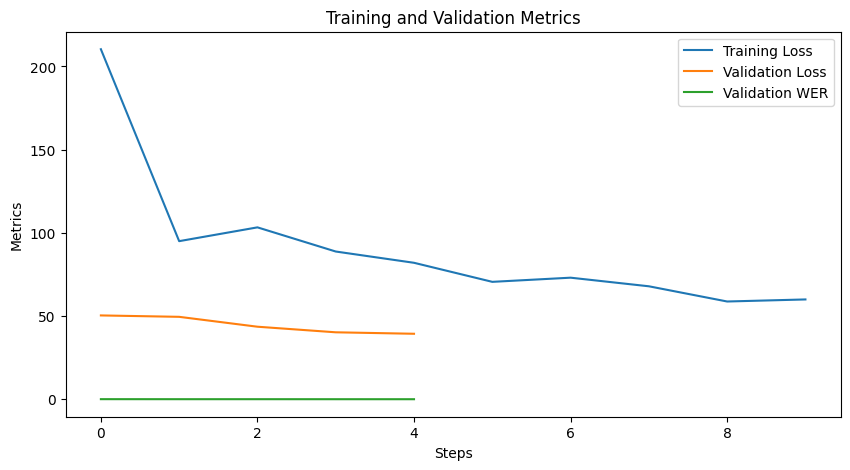

In [10]:
# Generate and save training plot
metrics = trainer.state.log_history
train_loss = [x.get("loss", None) for x in metrics if "loss" in x]
eval_loss = [x.get("eval_loss", None) for x in metrics if "eval_loss" in x]
eval_wer = [x.get("eval_wer", None) for x in metrics if "eval_wer" in x]

steps = range(len(eval_loss))

plt.figure(figsize=(10, 5))
if train_loss:
    plt.plot(range(len(train_loss)), train_loss, label="Training Loss")
if eval_loss:
    plt.plot(steps, eval_loss, label="Validation Loss")
if eval_wer:
    plt.plot(steps, eval_wer, label="Validation WER")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training and Validation Metrics")
# plt.savefig("./training_plot.png")  # Save plot as PNG
plt.show()

# Get transcription with funetuned model on dataset cv-valid-test.csv

The fune-tuned model **wav2vec2-large-960h-cv** which is saved in
`/asr-train/wav2vec2-large-960h-cv` will be loaded in asr_api server

Repeat the steps of **Task 2d** to get the updated cv-valid-test.csv with **generated_text** column as following:

1. **copy cv-valid-test dataset and the csv**

```bash
    $ cd xxx/JohnL-handsOn/asr-train
    
    $ cp -r xxx/cv-valid-test ./ 
    $ cp -r xxx/cv-valid-test.csv ./cv-valid-test/
```
2. **Launch asr_aip & load the fune-tuning model**

```bash
    # the following input parameter -mi
    # 1 is for choosing  'facebook/wav2vec2-large-960h', 
    # 2 for the fune-tuned model: 'wav2vec2-large-960h-cv'
    $ python ../asr/asr_api.py -mi 2 
  
```
3. **launch cv-decode.py to update cv-valid-test.csv with generated_text column**
```bash
    # -csv to specify the input csv file to be processed
    # -af to specify the input audio folder to be processed
    $ python ../asr/cv-decode.py -csv ./cv-valid-test/cv-valid-test.csv -af ./cv-valid-test
```


# Performance evaluation for Fune-tuned model on dataset cv-valid-test.csv 

To evaluate the fune-tuning performance for **Task 3c** as following script:

Overall WER: 6.91%


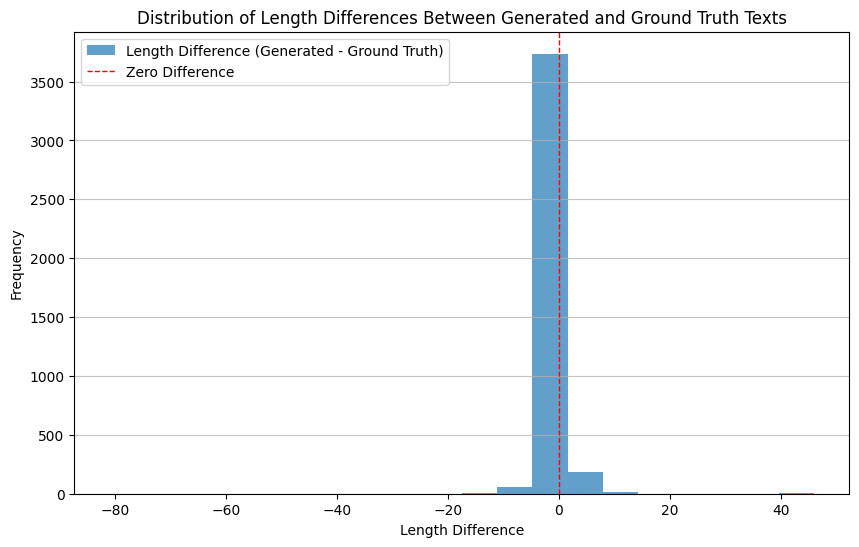

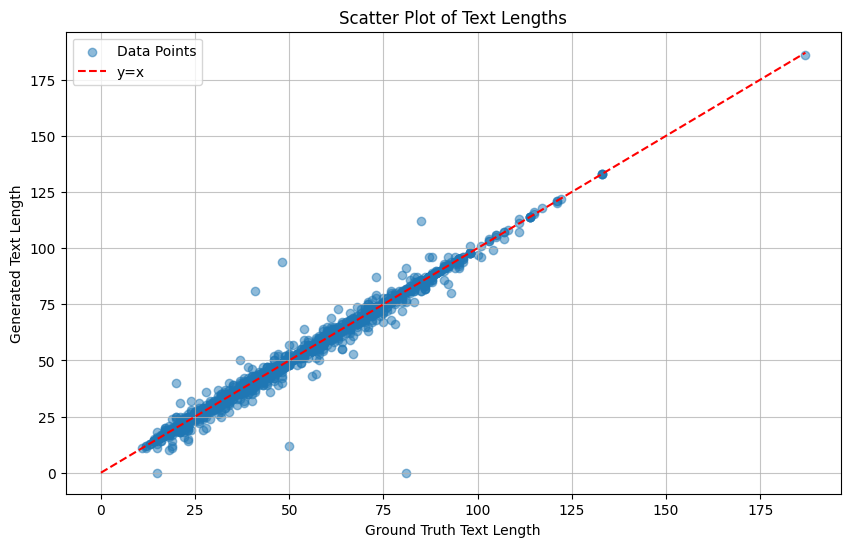

In [11]:
# Evaluate Fine-Tuning Performance 

import pandas as pd
import matplotlib.pyplot as plt
from evaluate import load
import re

# Step 1: Load the Dataset
file_path = "./cv-valid-test/cv-valid-test.csv"  
data = pd.read_csv(file_path)

# Ensure required columns exist
if not {"text", "generated_text"}.issubset(data.columns):
    raise ValueError("Dataset must contain 'text' and 'generated_text' columns.")

# Step 2: Normalize Text
chars_to_ignore_regex = r'[\,\?\.\!\-\;\:"]'  # Characters to ignore during WER computation

def normalize_text(text):
    if isinstance(text, str):
        return re.sub(chars_to_ignore_regex, '', text).lower().strip()
    return ""


data["text"] = data["text"].apply(normalize_text)
data["generated_text"] = data["generated_text"].apply(normalize_text)

# Step 3: Compute WER
wer_metric = load("wer")
wer_score = wer_metric.compute(predictions=data["generated_text"].tolist(), references=data["text"].tolist())

# Log the performance
print(f"Overall WER: {wer_score:.2%}")

# Save results to a file
with open("performance_log.txt", "w") as log_file:
    log_file.write(f"Overall WER: {wer_score:.2%}\n")

# Step 4: Visualization
# Compare length of generated text vs ground truth
lengths = data.apply(lambda row: len(row["generated_text"]) - len(row["text"]), axis=1)

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, alpha=0.7, label="Length Difference (Generated - Ground Truth)")
plt.axvline(0, color='r', linestyle='dashed', linewidth=1, label="Zero Difference")
plt.xlabel("Length Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Length Differences Between Generated and Ground Truth Texts")
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

# Scatter plot of text lengths
plt.figure(figsize=(10, 6))
plt.scatter(data["text"].apply(len), data["generated_text"].apply(len), alpha=0.5, label="Data Points")
plt.plot([0, max(data["text"].apply(len))], [0, max(data["text"].apply(len))], color="red", linestyle="dashed", label="y=x")
plt.xlabel("Ground Truth Text Length")
plt.ylabel("Generated Text Length")
plt.title("Scatter Plot of Text Lengths")
plt.legend()
plt.grid(alpha=0.75)
plt.show()